# IRM with hyperparameter scan

In our previous notebook, IRM didn't have an impact on the performance on a novel environment. That is likely because we were optimising hyperparameters for performance on data drawn from the training environments. Here we'll use performance on a holdout environment for training.

We'll train on spring + summer, choose a model based on MSE on fall, and test performance in a novel environment on winter.

In [1]:
import pandas as pd
import numpy as np

import torch

from torch import nn, optim, autograd
from torch.nn import functional as F

from sklearn.model_selection import train_test_split

from ax import optimize

Restrict to one year. There is nothing in the data to account for the growth of bike sharing from one year to the next.

In [2]:
df = pd.read_csv('../../../data/Bike-Sharing-Dataset/hour.csv')
df = df[df.yr == 0]

In [3]:
day_dummies = pd.get_dummies(df['weekday'])
day_dummies.columns = ['sun', 'mon', 'tues', 'wed', 'thurs', 'fri', 'sat']

In [4]:
weather_dummies = pd.get_dummies(df['weathersit'], drop_first=True)
weather_dummies.columns = ['misty', 'rainy', 'snowy']

In [5]:
features = [
    'holiday', 'workingday',
    'sun', 'mon', 'tues', 'wed', 'thurs', 'fri', 'sat', 'hr',
    'misty', 'rainy', 'snowy',
    'temp', 'atemp', 'hum', 'windspeed'
]

In [6]:
environment = ['season']

In [7]:
target = ['cnt']

In [8]:
df_ = (
    df
    .merge(weather_dummies, left_index=True, right_index=True)
    .merge(day_dummies, left_index=True, right_index=True)
    [features + environment + target]
)

In [9]:
def construct_env(df):
    return {
        'features': torch.Tensor(
            df.drop(environment + target,
                    axis='columns')
              .to_numpy()
        ),
        'target': torch.Tensor(df['cnt'].to_numpy()).unsqueeze(dim=1)
    }

The net architecture is pretty arbitrary.

In [10]:
class NN(nn.Module):
    def __init__(self, n_features, hidden_dim):
        super(NN, self).__init__()
        self.hidden1 = nn.Linear(n_features, hidden_dim)
        self.hidden2 = nn.Linear(hidden_dim, hidden_dim)
        self.output = nn.Linear(hidden_dim, 1)
        
    def forward(self, x):
        x = F.relu(self.hidden1(x))
        x = F.relu(self.hidden2(x))
        x = self.output(x)
        return x

In [11]:
mse = nn.MSELoss(reduction='mean')

In [12]:
def penalty(predictions, targets):
    dummy = torch.tensor(1., requires_grad=True)
    loss = mse(predictions*dummy, targets)
    grad = autograd.grad(loss, [dummy], create_graph=True)[0]
    squared_grad_norm = (grad**2).sum()
    return squared_grad_norm

Define our environments. The pooled environment is to attack the problem from a usual "this is what we do in supervised learning" angle.

In [13]:
winter_df = df_[df_.season == 1]
fall_df = df_[df_.season == 4]
spring_df = df_[df_.season == 2]
summer_df = df_[df_.season == 3]

pooled_df = pd.concat([spring_df, summer_df, winter_df])

pooled_df_train, pooled_df_test = train_test_split(pooled_df, test_size=0.33, shuffle=True)

In [14]:
winter = construct_env(winter_df)
fall = construct_env(fall_df)
spring = construct_env(spring_df)
summer = construct_env(summer_df)

pooled_train = construct_env(pooled_df_train)
pooled_test = construct_env(pooled_df_test)

In [15]:
N_FEATURES = winter['features'].shape[1]

Pretty naive early stopping. Sample the test set MSE every hundred epochs. If it gets worse twice consecutively, stop and keep the last model. Should really keep the third last model, or else track a history of performance and choose the best.

In [16]:
def fit_model(hidden_dim, learning_rate):
    net = NN(N_FEATURES, hidden_dim)
    opt = optim.Adam(net.parameters(), learning_rate)

    errs = [np.inf, np.inf]
    for iteration in range(5000):
        preds = net(pooled_train['features'])
        err = mse(preds, pooled_train['target'])
        
        opt.zero_grad()
        err.backward()
        opt.step()
        
        if iteration % 100 == 0:
            errs.append(
                mse(
                    net(pooled_test['features']), pooled_test['target']
                )
            )
            errs = errs[-3:]
        
            # early stopping - stop if validation error increases
            if errs[-3] <= errs[-2] <= errs[-1]:
                break
    
    return net

In [17]:
def fit_evaluate(hidden_dim, learning_rate):
    net = fit_model(hidden_dim, learning_rate)    
    return mse(net(pooled_test['features']), pooled_test['target']).item()

Perform Bayesian optimization for hyperparameter tuning. There's a risk of overfitting to the test set here but we'll live with it.

In [662]:
best_parameters, best_values, experiment, model = optimize(
    parameters=[
        {
            'name': 'hidden_dim',
            'type': 'range',
            'value_type': 'int',
            'bounds': [1, 20]
        },
        {
            'name': 'learning_rate',
            'type': 'range',
            'value_type': 'float',
            'bounds': [1e-4, 1e-1]
        },
    ],
    evaluation_function = lambda p: fit_evaluate(
        p['hidden_dim'], p['learning_rate']
    ),
    minimize=True,
    total_trials=20
)

[INFO 02-25 13:56:18] ax.modelbridge.dispatch_utils: Using Bayesian Optimization generation strategy: GenerationStrategy(name='Sobol+GPEI', steps=[Sobol for 5 arms, GPEI for subsequent arms], generated 0 arm(s) so far). Iterations after 5 will take longer to generate due to model-fitting.
[INFO 02-25 13:56:18] ax.service.managed_loop: Started full optimization with 20 steps.
[INFO 02-25 13:56:18] ax.service.managed_loop: Running optimization trial 1...
[INFO 02-25 13:56:21] ax.service.managed_loop: Running optimization trial 2...
[INFO 02-25 13:56:29] ax.service.managed_loop: Running optimization trial 3...
[INFO 02-25 13:56:30] ax.service.managed_loop: Running optimization trial 4...
[INFO 02-25 13:56:33] ax.service.managed_loop: Running optimization trial 5...
[INFO 02-25 13:56:36] ax.service.managed_loop: Running optimization trial 6...
[INFO 02-25 13:56:38] ax.service.managed_loop: Running optimization trial 7...
[INFO 02-25 13:56:46] ax.service.managed_loop: Running optimization t

In [663]:
best_values

({'objective': 1750.1927726146123},
 {'objective': {'objective': 3.808925817174046}})

In [664]:
best_parameters

{'hidden_dim': 19, 'learning_rate': 0.059443260831255736}

Having chosen the best hyperparams, re-fit the net with them. In principle we should be able to wire Ax up to return the best model (I think?).

In [673]:
best_net = fit_model(best_parameters['hidden_dim'], best_parameters['learning_rate'])

In [24]:
best_net = fit_model(20, 0.05)

Plot predictions vs ground truth on train, test and holdout sets.

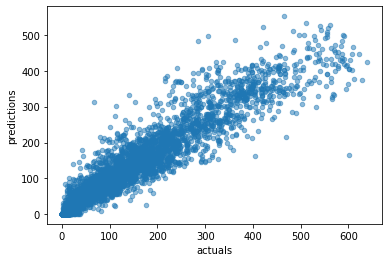

In [25]:
(
    pd.DataFrame({
        'predictions': best_net(pooled_train['features']).squeeze().tolist(),
        'actuals': pooled_train['target'].squeeze().tolist()
    }).plot(
        x='actuals',
        y='predictions',
        kind='scatter',
        alpha=0.5,
#         xlim=(0,800),
#         ylim=(-100,800)
    )
)

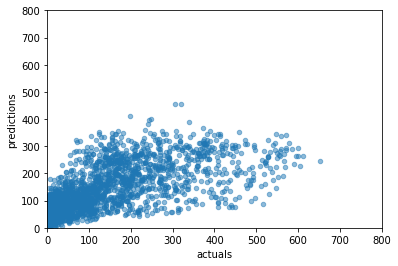

In [20]:
(
    pd.DataFrame({
        'predictions': best_net(pooled_test['features']).squeeze().tolist(),
        'actuals': pooled_test['target'].squeeze().tolist()
    }).plot(
        x='actuals',
        y='predictions',
        kind='scatter',
        alpha=0.5,
        xlim=(0,800),
        ylim=(0,800)
    )
)

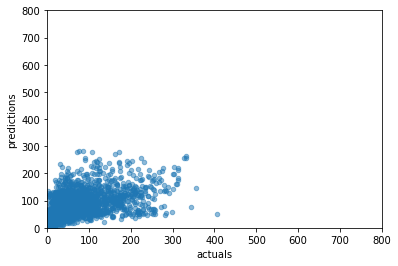

In [21]:
(
    pd.DataFrame({
        'predictions': best_net(winter['features']).squeeze().tolist(),
        'actuals': winter['target'].squeeze().tolist()
    }).plot(
        x='actuals',
        y='predictions',
        kind='scatter',
        alpha=0.5,
        xlim=(0,800),
        ylim=(0,800)
    )
)

The MSE on the holdout set should be smaller than train/test, even if the model is not well suited to it, because in winter there are fewer rentals, so given the same predictive power, the raw value of the errors is smaller. We could compare performance with train/test using some sort of scaled error, but what we're really interested in is the comparison with IRM.

In [678]:
mse(best_net(winter['features']), winter['target']).item()

1057.149658203125

## Once more, with IRM

In [733]:
def fit_irm(hidden_dim, learning_rate, n_wait, scale):
    net = NN(N_FEATURES, hidden_dim)
    opt = optim.Adam(net.parameters(), learning_rate)

    env1 = spring.copy()
    env2 = summer.copy()
    errs = [np.inf, np.inf]
    
    for iteration in range(10000):
        for env in [env1, env2]:
            preds = net(env['features'])
            env['error'] = mse(preds, env['target'])
            env['penalty'] = penalty(preds, env['target'])
        
        train_error = torch.stack([env1['error'], env2['error']]).mean()
        train_penalty = torch.stack([env1['penalty'], env2['penalty']]).mean()

        if iteration < n_wait:
            loss = train_error
        else:
            loss = (scale * train_error + train_penalty)
        
        opt.zero_grad()
        loss.backward()
        opt.step()
        
        if (iteration % 100 == 0) & (iteration > n_wait):
            errs.append(mse(net(fall['features']), fall['target']))
                    
            # early stopping - stop if validation error increases
            if errs[-3] <= errs[-2] <= errs[-1]:
                break
    
    return net

In [734]:
def fit_evaluate_irm(hidden_dim, learning_rate, n_wait, scale):
    net = fit_irm(hidden_dim, learning_rate, n_wait, scale)
    return mse(net(fall['features']), fall['target']).item()

As before, but we have more parameters to search over.

In [735]:
irm_best_parameters, irm_best_values, irm_experiment, irm_model = optimize(
    parameters=[
        {
            'name': 'hidden_dim',
            'type': 'range',
            'value_type': 'int',
            'bounds': [1, 20]
        },
        {
            'name': 'learning_rate',
            'type': 'range',
            'value_type': 'float',
            'bounds': [1e-4, 1e-1]
        },
        {
            'name': 'n_wait',
            'type': 'range',
            'value_type': 'int',
            'bounds': [1, 1e3]
        },
        {
            'name': 'scale',
            'type': 'range',
            'value_type': 'float',
            'bounds': [1e-8, 1e-1]
        }
    ],
    evaluation_function = lambda p: fit_evaluate_irm(
        p['hidden_dim'], p['learning_rate'], p['n_wait'], p['scale']
    ),
    minimize=True,
    total_trials=20
)

[INFO 02-25 15:50:59] ax.modelbridge.dispatch_utils: Using Bayesian Optimization generation strategy: GenerationStrategy(name='Sobol+GPEI', steps=[Sobol for 5 arms, GPEI for subsequent arms], generated 0 arm(s) so far). Iterations after 5 will take longer to generate due to model-fitting.
[INFO 02-25 15:50:59] ax.service.managed_loop: Started full optimization with 20 steps.
[INFO 02-25 15:50:59] ax.service.managed_loop: Running optimization trial 1...
[INFO 02-25 15:51:00] ax.service.managed_loop: Running optimization trial 2...
[INFO 02-25 15:51:05] ax.service.managed_loop: Running optimization trial 3...
[INFO 02-25 15:51:07] ax.service.managed_loop: Running optimization trial 4...
[INFO 02-25 15:51:08] ax.service.managed_loop: Running optimization trial 5...
[INFO 02-25 15:51:28] ax.service.managed_loop: Running optimization trial 6...
[INFO 02-25 15:51:30] ax.service.managed_loop: Running optimization trial 7...
[INFO 02-25 15:51:32] ax.service.managed_loop: Running optimization t

In [736]:
irm_best_parameters

{'hidden_dim': 6,
 'learning_rate': 0.02883597158933674,
 'n_wait': 358,
 'scale': 0.03298565569359665}

In [737]:
irm_best_values

({'objective': 12669.25428753565},
 {'objective': {'objective': 16.47239938746049}})

In [738]:
best_irm_net = fit_irm(
    irm_best_parameters['hidden_dim'],
    irm_best_parameters['learning_rate'],
    irm_best_parameters['n_wait'],
    irm_best_parameters['scale']
)

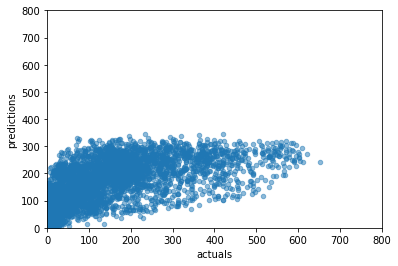

In [739]:
(
    pd.DataFrame({
        'predictions': best_irm_net(pooled_train['features']).squeeze().tolist(),
        'actuals': pooled_train['target'].squeeze().tolist()
    }).plot(
        x='actuals',
        y='predictions',
        kind='scatter',
        alpha=0.5,
        xlim=(0,800),
        ylim=(0,800)
    )
)

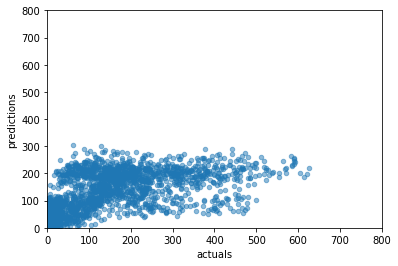

In [740]:
(
    pd.DataFrame({
        'predictions': best_irm_net(fall['features']).squeeze().tolist(),
        'actuals': fall['target'].squeeze().tolist()
    }).plot(
        x='actuals',
        y='predictions',
        kind='scatter',
        alpha=0.5,
        xlim=(0,800),
        ylim=(0,800)
    )
)

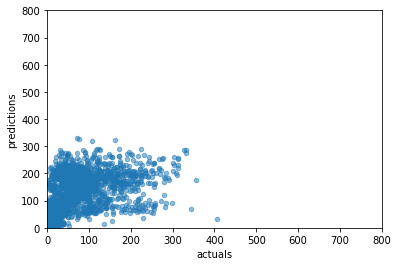

In [741]:
# irm validation set

(
    pd.DataFrame({
        'predictions': best_irm_net(winter['features']).squeeze().tolist(),
        'actuals': winter['target'].squeeze().tolist()
    }).plot(
        x='actuals',
        y='predictions',
        kind='scatter',
        alpha=0.5,
        xlim=(0,800),
        ylim=(0,800)
    )
)

Performance of IRM kinda sucks. Seems the invariance penalty is inhibiting learning. It's definitely not clear that even a net that is well trained with IRM could substantially outperform regular supervised learning, because the supervised predictor above doesn't suck on the hold out set like we thought it might.

In [742]:
print('rmse of non-IRM model on non-IRM test set:', np.sqrt(best_values[0]['objective']))

rmse of non-IRM model on non-IRM test set: 41.83530533669633


In [743]:
print('rmse of IRM model on IRM test set (fall season):',np.sqrt(irm_best_values[0]['objective']))

rmse of IRM model on IRM test set (fall season): 112.55778199456336


In [744]:
print('rmse of non-IRM on holdout winter season:', np.sqrt(mse(best_net(winter['features']), winter['target']).item()))

rmse of non-IRM on holdout winter season: 32.51383794945046


In [745]:
print('rmse of IRM on holdout winter season:', np.sqrt(mse(best_irm_net(winter['features']), winter['target']).item()))

rmse of IRM on holdout winter season: 90.19991360340929
